# Baseline: CPU/GPU performance comparison

In this notebook, I will compare the inference speed of a transformer neural network on a cpu, gpu

The model will additionally be compared with the optimized compiled model (PyTorch 2.0 feature)

Data:
- from this paper: https://arxiv.org/pdf/2208.03938.pdf
- https://github.com/NetManAIOps/KPI-Anomaly-Detection
- https://github.com/rob-med/awesome-TS-anomaly-detection
- used in this paper: https://www.mdpi.com/2073-8994/11/11/1350

```
The dataset consists of KPI (key performace index) time series data from many real scenarios of Internet companies with ground truth label. KPIs fall into two broad categories: service KPIs and machine KPIs. Service KPIs are performance metrics that reflect the size and quality of a Web service, such as page response time, page views, and number of connection errors. Machine KPIs are performance indicators that reflect the health of the machine (server, router, switch), such as CPU utilization, memory utilization, disk IO, network card throughput, etc.

Dataset Descriptions:

In order to train the anomaly detection algorithm, the training KPI data provided by us is shown in table 1, including four columns: KPI ID, timestamp, the value of the KPI at that time, and whether the time is abnormal (label).
```

In [562]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [563]:
from pathlib import Path
DATA_DIR = Path('../data/KPI-Anomaly-Detection/Preliminary_dataset')

In [564]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset preparation

In [565]:
df = pd.read_csv(DATA_DIR/'train.csv', index_col='timestamp')
df = df.sort_index()
df['time'] = df.index - df.index[0]

In [566]:
df.head()

,value,label,KPI ID,time
timestamp,,,,
1467302400,0.197575,0,07927a9a18fa19ae,0
1467302700,0.149877,0,07927a9a18fa19ae,300
1467303000,0.078893,0,07927a9a18fa19ae,600
1467303300,0.012004,0,07927a9a18fa19ae,900
1467303600,-0.022222,0,07927a9a18fa19ae,1200


In [567]:
pd.crosstab(df['KPI ID'], df['label'], normalize='index').sort_values(1, ascending=False).head()

label,0,1
KPI ID,,
02e99bd4f6cfb33f,0.917938,0.082062
1c35dbf57f55f5e4,0.925644,0.074356
18fbb1d5a5dc099d,0.939107,0.060893
da403e4e3f87c9e0,0.940590,0.059410
88cf3a776ba00e7c,0.952534,0.047466


In [568]:
df = df[df['KPI ID'] == '02e99bd4f6cfb33f'].copy()
df['time'] = df.index - df.index[0]

In [569]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128562 entries, 1493568000 to 1501475640
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   value   128562 non-null  float64
 1   label   128562 non-null  int64  
 2   KPI ID  128562 non-null  object 
 3   time    128562 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 4.9+ MB


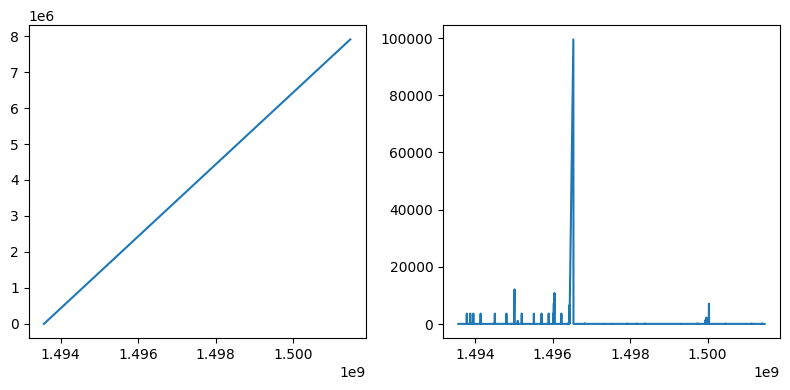

In [570]:
fig,axs=plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(df.time);
plt.subplot(1, 2, 2)
plt.plot(df.time.diff())
plt.tight_layout();

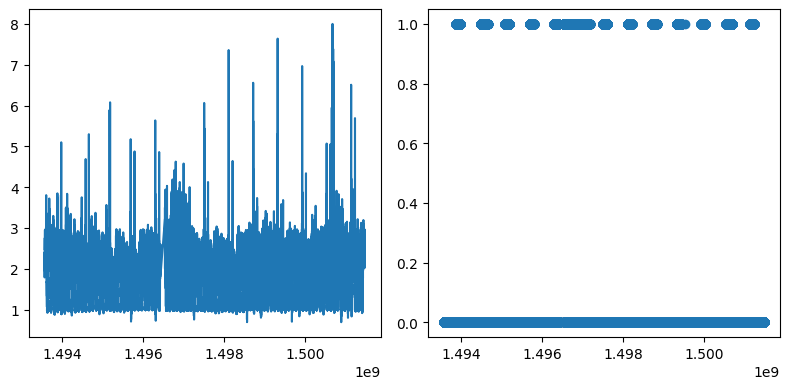

In [571]:
fig,axs=plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(df.value);
plt.subplot(1, 2, 2)
plt.scatter(df.index, df.label)
plt.tight_layout();

lets only take the values for timestamp > 1.49 * 1e9

In [572]:
df = df[df.index > 1.49 * 1e9].copy()
df['time'] = df.index - df.index[0]

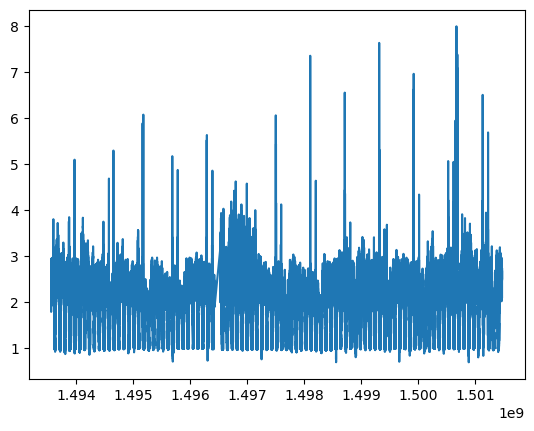

In [573]:
plt.plot(df.value)

outliers are clearly visible...

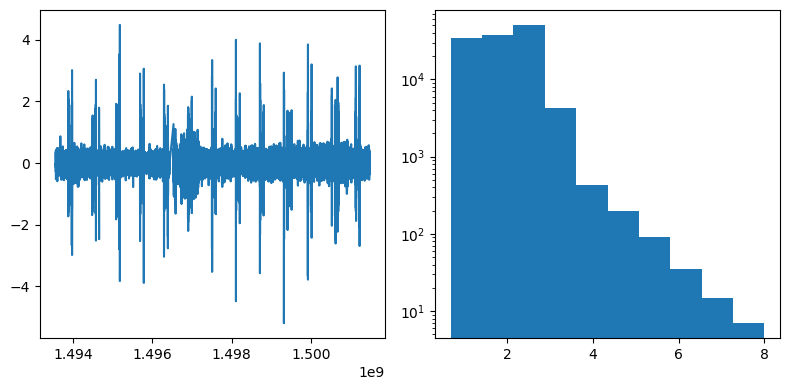

In [574]:
fig,axs=plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(df.value.diff())
plt.subplot(1, 2, 2)
plt.hist(df.value)
plt.yscale('log')
plt.tight_layout();

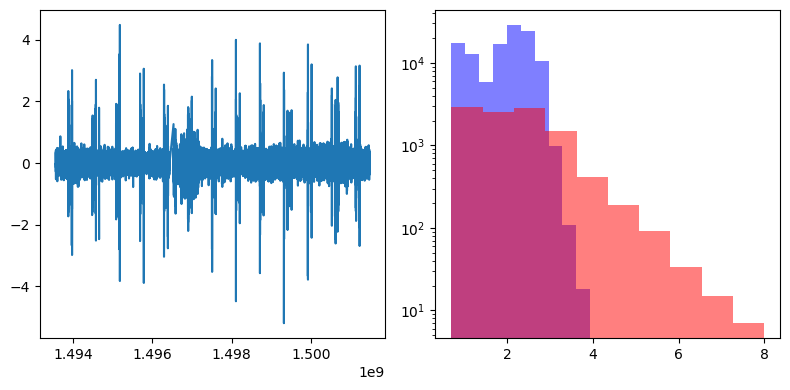

In [575]:
fig,axs=plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(df.value.diff())
plt.subplot(1, 2, 2)
plt.hist(df.query('label==0').value, color='blue', alpha=0.5, label='0')
plt.hist(df.query('label==1').value, color='red', alpha=0.5, label='1')
plt.yscale('log')
plt.tight_layout();

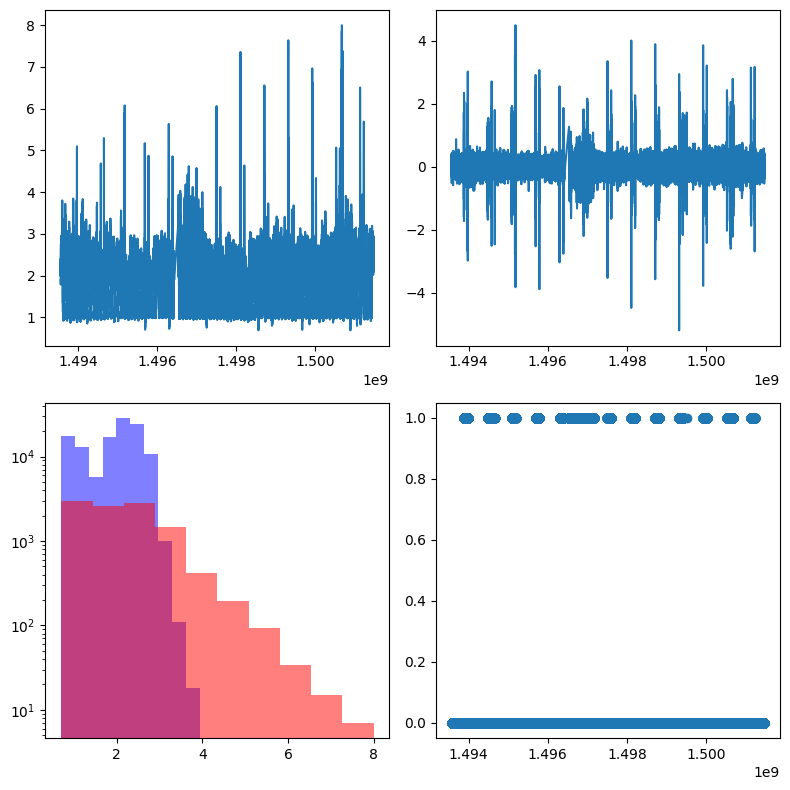

In [576]:
fig,axs=plt.subplots(2, 2, figsize=(8, 8))
plt.sca(axs[0, 0])
plt.plot(df.value)
plt.sca(axs[0, 1])
plt.plot(df.value.diff())
plt.sca(axs[1, 0])
plt.hist(df.query('label==0').value, color='blue', alpha=0.5, label='0')
plt.hist(df.query('label==1').value, color='red', alpha=0.5, label='1')
plt.yscale('log')
plt.sca(axs[1, 1])
plt.scatter(df.index, df.label)
plt.tight_layout();

In [577]:
df.label.value_counts(normalize=True)

label
0    0.917938
1    0.082062
Name: proportion, dtype: float64

timeseries looks quite stationary, anomalies seem to be nicely interleaved between normal observations with respect to time

the dataset is unbalanced (only 8% of samples are anomalies)

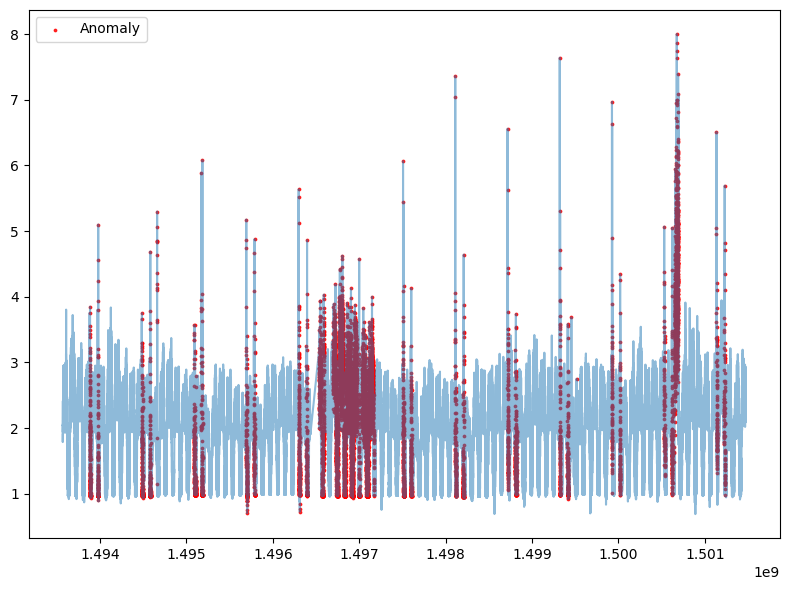

In [578]:
fig,axs=plt.subplots(1, 1, figsize=(8, 6))

plt.plot(df.value, alpha=0.5)
t = df.query('label==1')
plt.scatter(t.index, t.value, color='red', alpha=0.8, label='Anomaly', s=3, zorder=1)
plt.legend()
plt.tight_layout();

some anomalies are quite clear (very high values)

notice that we also have a time split here (somehwre around 1.4965*1e9 timestamp) => lets only take the first part of the time series

In [579]:
df.time.diff().sort_values(ascending=False).head()

timestamp
1496538120    99540.0
1495018920    12120.0
1496052000    10860.0
1496034000     7260.0
1500038160     7080.0
Name: time, dtype: float64

In [580]:
df = df.query('timestamp < 1496538120').copy()
df['time'] = df.index - df.index[0]
df['vd'] = df['value'].diff()

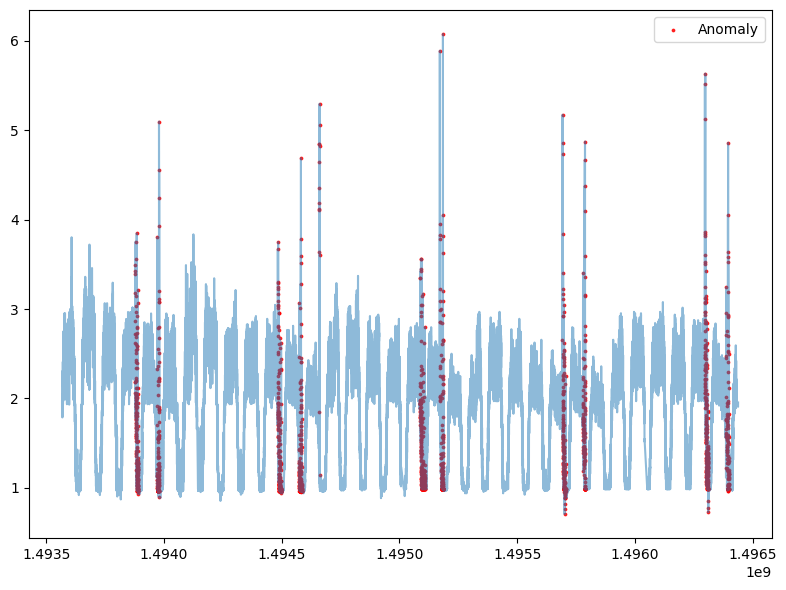

In [581]:
fig,axs=plt.subplots(1, 1, figsize=(8, 6))

plt.plot(df.value, alpha=0.5)
t = df.query('label==1')
plt.scatter(t.index, t.value, color='red', alpha=0.8, label='Anomaly', s=3, zorder=1)
plt.legend()
plt.tight_layout();

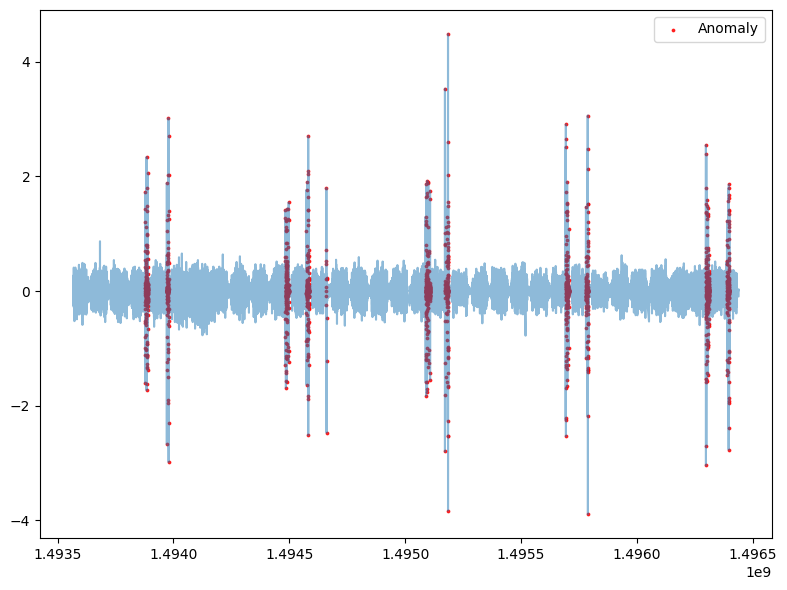

In [582]:
fig,axs=plt.subplots(1, 1, figsize=(8, 6))

plt.plot(df.vd, alpha=0.5)
t = df.query('label==1')
plt.scatter(t.index, t.vd, color='red', alpha=0.8, label='Anomaly', s=3, zorder=1)
plt.legend()
plt.tight_layout();

looks nice! (althought the anomalies are grouped together, might be bad for evaluation...)

In [583]:
df.label.value_counts(normalize=True)

label
0    0.958799
1    0.041201
Name: proportion, dtype: float64

lets also split it into train and test

In [584]:
split_idx = 1.495*1e9
tr = df[df.index < split_idx].copy()
te = df[df.index >= split_idx].copy()

In [585]:
tr.label.value_counts(normalize=True), te.label.value_counts(normalize=True)

(label
 0    0.96727
 1    0.03273
 Name: proportion, dtype: float64,
 label
 0    0.950141
 1    0.049859
 Name: proportion, dtype: float64)

In [586]:
len(tr), len(te)

(23495, 22985)

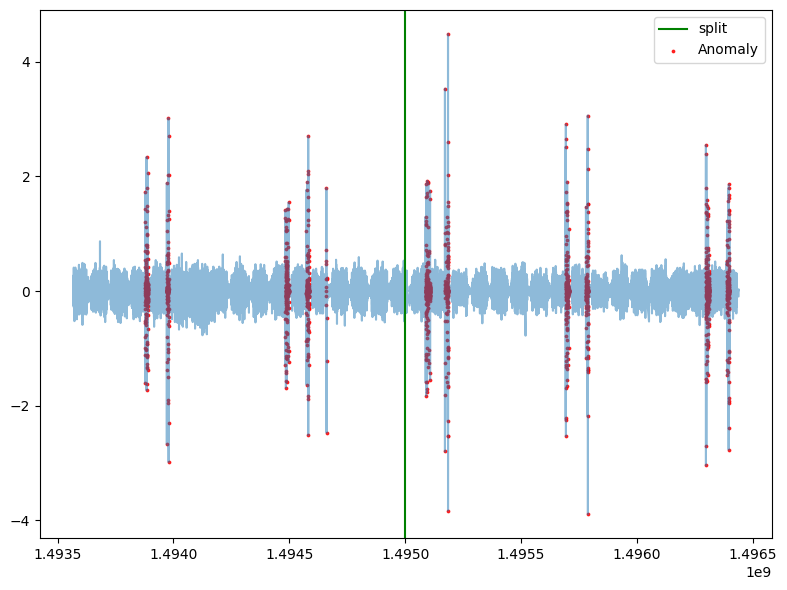

In [587]:
fig,axs=plt.subplots(1, 1, figsize=(8, 6))

plt.plot(df.vd, alpha=0.5)
plt.axvline(split_idx, color='g', label='split')
t = df.query('label==1')
plt.scatter(t.index, t.vd, color='red', alpha=0.8, label='Anomaly', s=3, zorder=1)
plt.legend()
plt.tight_layout();

## Baseline solution

Here I compare the performance (accuracy, latency and thoughput) of a CPU/GPU and FPGA implementation

I will use a simple **Bollinger bands** on value diffs for now

In [588]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# https://stackoverflow.com/a/71505610
# https://stackoverflow.com/a/25823885
from timeit import default_timer as timer

## Bollinger bands

In [589]:
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

In [590]:
X_tr = tr.vd.values
X_te = te.vd.values
y_tr = tr.label.values
y_te = te.label.values

#### CPU

training: lets optimize f1 score on the train dataset

In [591]:
from src.BB import BB

> accuracy

In [592]:
window_size = 20
bb = BB(init_obs=X_tr[-window_size:], window_size=window_size, num_std=2)
y_pr = bb.predict_many(X_te)

In [593]:
evaluate_model(y_te, y_pr)

Accuracy: 0.9075048944964107
Precision: 0.1016260162601626
Recall: 0.10907504363001745
F1-score: 0.10521885521885521


very low precision/recall, as expected

In [594]:
te['pred'] = y_pr

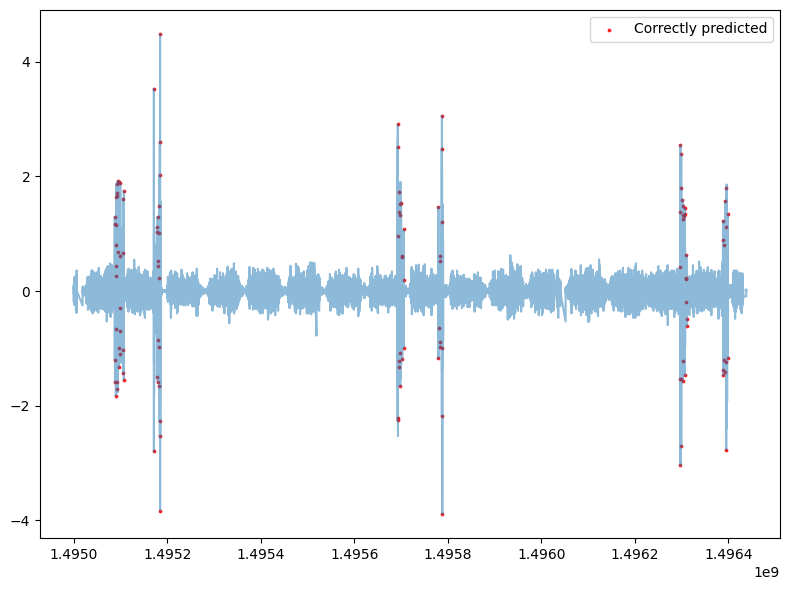

In [595]:
fig,axs=plt.subplots(1, 1, figsize=(8, 6))

plt.plot(te.vd, alpha=0.5)
t = te.query('label==1 & pred==1')
plt.scatter(t.index, t.vd, color='red', alpha=0.8, label='Correctly predicted', s=3, zorder=1)
plt.legend()
plt.tight_layout();

> latency and throughput without vectorisation

In [596]:
bb = BB(init_obs=X_tr[-window_size:], window_size=window_size, num_std=2)

# latency
rs = []
times = []
for x in X_te:
    start = timer()
    y = bb.predict_one(x)
    end = timer()
    bb.update_state(x)
    rs.append(y)
    times.append(end-start)
rs = np.array(rs)
times = pd.Series(times)  # in seconds
times *= 1e6  # in microseconds

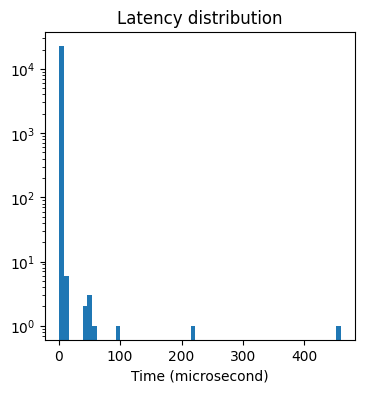

In [597]:
fig,axs=plt.subplots(1, 1, figsize=(4, 4))
plt.hist(times, bins=60)
plt.yscale('log')
plt.title('Latency distribution')
plt.xlabel('Time (microsecond)');

> without the outlier

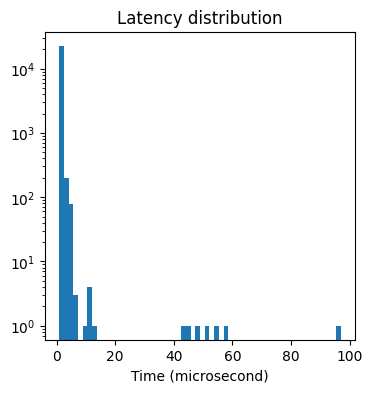

In [598]:
fig,axs=plt.subplots(1, 1, figsize=(4, 4))
plt.hist(times[times<200], bins=60)
plt.yscale('log')
plt.title('Latency distribution')
plt.xlabel('Time (microsecond)');

In [599]:
times.quantile([0.1, 0.5, 0.75, 0.9, 0.95, 0.99])

0.10    0.978998
0.50    1.034998
0.75    1.072000
0.90    1.121000
0.95    1.179000
0.99    3.183122
dtype: float64

In [600]:
times.mean()

1.137111037604161

mean latency is 1 microsecond

In [601]:
# throughput without vectorisation
throughput_not_vec = len(X_te) / sum(times/1e6) 
print(f'Throughput (not vectorised): {throughput_not_vec} samples/second')

Throughput (not vectorised): 879421.5929052562 samples/second


> throughput vectorised

In [602]:
# throughput
N_RUNS = 1000
times = []
for _ in range(N_RUNS):
    bb = BB(init_obs=X_tr[-window_size:], window_size=window_size, num_std=2)
    start = timer()
    y_pr = bb.predict_many(X_te)
    end = timer()
    times.append(end-start)
times = pd.Series(times)  # in seconds
times *= 1e6  # in microseconds

In [603]:
throughputs = len(X_te) / (times/1e6)

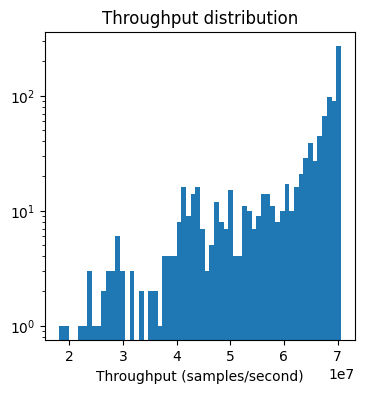

In [604]:
fig,axs=plt.subplots(1, 1, figsize=(4, 4))
plt.hist(throughputs, bins=60)
plt.yscale('log')
plt.title('Throughput distribution')
plt.xlabel('Throughput (samples/second)');

In [605]:
# throughput with vectorisation
throughput_not_vec = throughputs.mean()
print(f'Throughput (vectorised): {throughput_not_vec} samples/second')

Throughput (vectorised): 62208538.87569586 samples/second


good improvement over not vectorised version

### GPU

In [606]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available(), device)
torch.cuda.empty_cache()

True cuda


In [607]:
import bottleneck as bn
from src.BB import BB_gpu, moving_mean_std

In [608]:
X_tr = tr.vd.values
X_te = te.vd.values
y_tr = tr.label.values
y_te = te.label.values

X_tr = torch.tensor(X_tr).to(device)
X_te = torch.tensor(X_te).to(device)

# y_tr = torch.tensor(y_tr).to(device)
# y_te = torch.tensor(y_te).to(device)

> accuracy

In [609]:
window_size = 20
bb = BB_gpu(init_obs=X_tr[-window_size:], window_size=window_size, num_std=2)
y_pr = bb.predict_many(X_te)
y_pr = y_pr.to('cpu')

In [610]:
evaluate_model(y_te, y_pr)

Accuracy: 0.9075048944964107
Precision: 0.1016260162601626
Recall: 0.10907504363001745
F1-score: 0.10521885521885521


very low precision/recall, as expected

In [611]:
te['pred'] = y_pr

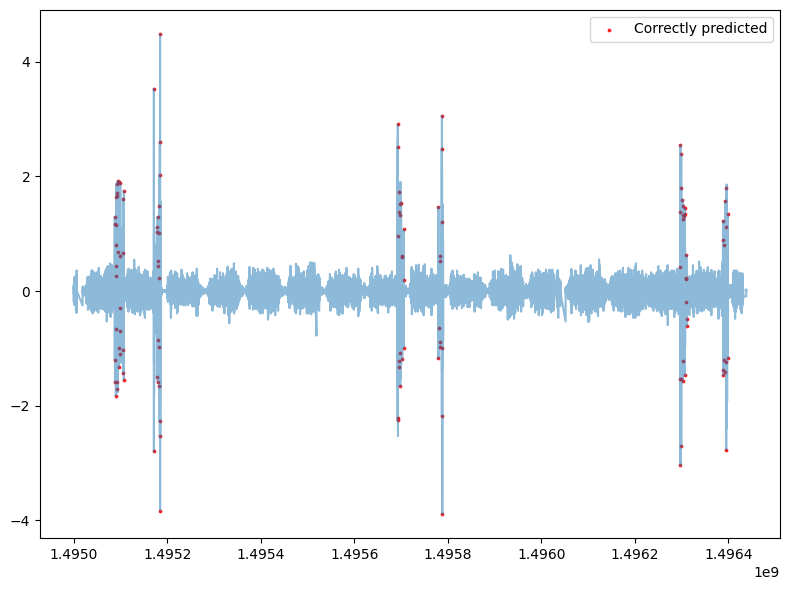

In [612]:
fig,axs=plt.subplots(1, 1, figsize=(8, 6))

plt.plot(te.vd, alpha=0.5)
t = te.query('label==1 & pred==1')
plt.scatter(t.index, t.vd, color='red', alpha=0.8, label='Correctly predicted', s=3, zorder=1)
plt.legend()
plt.tight_layout();

same predictions as CPU version

> latency and throughput without vectorisation

In [613]:
bb = BB_gpu(init_obs=X_tr[-window_size:], window_size=window_size, num_std=2)

# latency
rs = []
times = []
for x in X_te:
    start = timer()
    y = bb.predict_one(x)
    end = timer()
    bb.update_state(x)
    rs.append(y)
    times.append(end-start)
rs = np.array(rs)
times = pd.Series(times)  # in seconds
times *= 1e6  # in microseconds

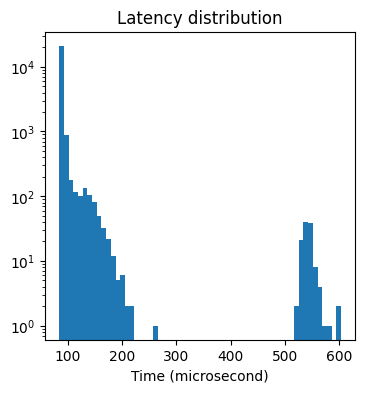

In [614]:
fig,axs=plt.subplots(1, 1, figsize=(4, 4))
plt.hist(times, bins=60)
plt.yscale('log')
plt.title('Latency distribution')
plt.xlabel('Time (microsecond)');

In [615]:
times.quantile([0.1, 0.5, 0.75, 0.9, 0.95, 0.99])

0.10     85.854399
0.50     86.839002
0.75     87.685999
0.90     91.115398
0.95     98.366000
0.99    156.234000
dtype: float64

In [616]:
# throughput without vectorisation
throughput_not_vec = len(X_te) / sum(times/1e6) 
print(f'Throughput (not vectorised): {throughput_not_vec} samples/second')

Throughput (not vectorised): 10949.416168447493 samples/second


much slower than the cpu version (which is expected since we are moving the data around too much)

> throughput vectorised

In [617]:
# throughput
N_RUNS = 1000
times = []
for _ in range(N_RUNS):
    bb = BB_gpu(init_obs=X_tr[-window_size:], window_size=window_size, num_std=2)
    start = timer()
    y_pr = bb.predict_many(X_te)
    end = timer()
    times.append(end-start)
times = pd.Series(times)  # in seconds
times *= 1e6  # in microseconds

In [618]:
throughputs = len(X_te) / (times/1e6)

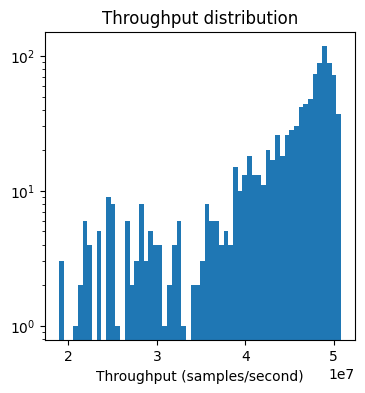

In [619]:
fig,axs=plt.subplots(1, 1, figsize=(4, 4))
plt.hist(throughputs, bins=60)
plt.yscale('log')
plt.title('Throughput distribution')
plt.xlabel('Throughput (samples/second)');

In [620]:
# throughput with vectorisation
throughput_not_vec = throughputs.mean()
print(f'Throughput (vectorised): {throughput_not_vec} samples/second')

Throughput (vectorised): 44728721.87220856 samples/second


smaller than the cpu version

that is expected, we cannot benefit a lot from a gpu for bollinger bands

### FPGA

TODO

## Transformer

Here I use a simple multihead attention layer to do the inference

the input features are simple the lags of the time series

In [842]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from src.transformer import MultiheadAttention

In [800]:
t = df.copy()
for lag in range(1, 10):
    t[f'lag_vd_{lag}'] = t['vd'].shift(lag)
    t[f'lag_label_{lag}'] = t['label'].shift(lag)
t = t.dropna()
tr_cols = [c for c in t.columns if 'lag' in c] + ['vd']

In [801]:
split_idx = 1.495*1e9
tr = t[t.index < split_idx].copy()
te = t[t.index >= split_idx].copy()

In [853]:
x = tr[tr_cols].values
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(tr.label.values, dtype=torch.float32)
print(x.shape, y.shape)

torch.Size([23485, 19]) torch.Size([23485])


In [951]:
loader = DataLoader(list(zip(x,y)), shuffle=False, batch_size=16)

In [950]:
input_dim = len(tr_cols)
embed_dim = 20
num_heads = 4

model = Transformer(input_dim, embed_dim, num_heads, output_dim=1)

In [952]:
n_epochs = 10
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [953]:
y_true_np = y_batch.numpy().ravel().astype(int).shape
y_pred_np = y_pred.detach().numpy().ravel().astype(int).shape

In [954]:
losses = []
f1s = []
for epoch in range(n_epochs):
    epoch_losses = []
    all_y_true = []
    all_y_preds = []
    print(f'{epoch=}')
    for X_batch, y_batch in loader:
        X_batch = X_batch.unsqueeze(0)
        y_batch = y_batch.unsqueeze(0)
        # so x shape is (batch_size, sequence length, features)
        
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

        epoch_losses.append(loss.detach().numpy())
        all_y_true.append(y_batch.detach().numpy())
        all_y_preds.append(y_pred.detach().numpy())
        
    all_y_true = np.hstack(all_y_true).astype(int).ravel()
    all_y_preds = np.hstack(all_y_preds).astype(int).ravel()
    
    epoch_losses = np.array(epoch_losses)
    epoch_losses = epoch_losses.mean()
    losses.append(epoch_losses)
    
    f1 = f1_score(all_y_true, all_y_preds)
    f1s.append(f1)

losses = np.array(losses)

epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9


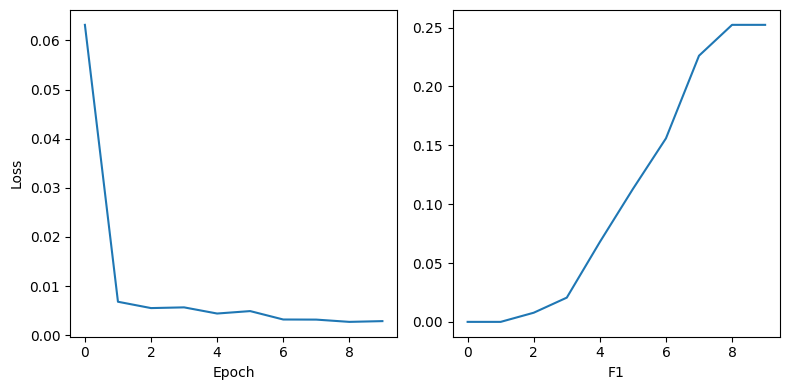

In [956]:
fig,axs=plt.subplots(1, 2, figsize=(8, 4))
plt.sca(axs[0])
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.sca(axs[1])
plt.plot(f1s)
plt.xlabel('Epoch')
plt.xlabel('F1')
plt.tight_layout();

a large improvement in terms of F1 score!

In [959]:
PATH = '../data/models/transformer_baseline'

In [958]:
# https://stackoverflow.com/a/49078976
torch.save(model.state_dict(), PATH)

### inference

In [962]:
model = Transformer(input_dim, embed_dim, num_heads, output_dim=1)
model.load_state_dict(torch.load(PATH))
model.eval();

> accuracy

In [964]:
x = te[tr_cols].values
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(te.label.values, dtype=torch.float32)
print(x.shape, y.shape)

torch.Size([22985, 19]) torch.Size([22985])


In [973]:
loader = DataLoader(list(zip(x,y)), shuffle=False, batch_size=16)

In [974]:
all_y_true = []
all_y_preds = []
for X_batch, y_batch in loader:
    X_batch = X_batch.unsqueeze(0)
    y_batch = y_batch.unsqueeze(0)
    # so x shape is (batch_size, sequence length, features)
    
    # forward pass
    y_pred = model(X_batch)

    all_y_true.append(y_batch.detach().numpy())
    all_y_preds.append(y_pred.detach().numpy())
    
all_y_true = np.hstack(all_y_true).astype(int).ravel()
all_y_preds = np.hstack(all_y_preds).astype(int).ravel()

In [975]:
evaluate_model(all_y_true, all_y_preds)

Accuracy: 0.9624972808353274
Precision: 1.0
Recall: 0.24781849912739964
F1-score: 0.39720279720279716


much bigger F1-Score on test

In [976]:
te['pred'] = all_y_preds

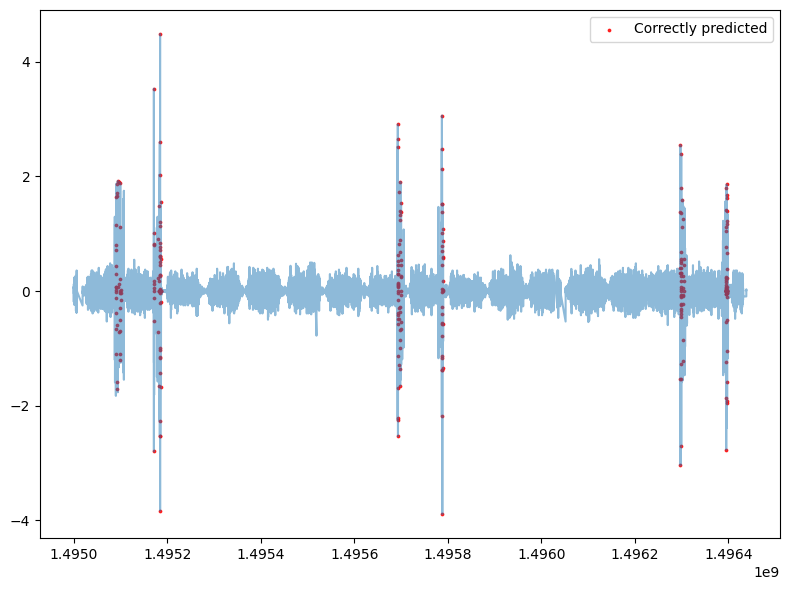

In [977]:
fig,axs=plt.subplots(1, 1, figsize=(8, 6))

plt.plot(te.vd, alpha=0.5)
t = te.query('label==1 & pred==1')
plt.scatter(t.index, t.vd, color='red', alpha=0.8, label='Correctly predicted', s=3, zorder=1)
plt.legend()
plt.tight_layout();

> speed on CPU

In [1000]:
times = []

all_y_true = []
all_y_preds = []
for X_batch, y_batch in loader:
    X_batch = X_batch.unsqueeze(0)
    y_batch = y_batch.unsqueeze(0)
    # so x shape is (batch_size, sequence length, features)
    
    start = timer()
    y_pred = model(X_batch)
    end = timer()

    times.extend([(end-start)]*X_batch.size(1))

    all_y_true.append(y_batch.detach().numpy())
    all_y_preds.append(y_pred.detach().numpy())
    
all_y_true = np.hstack(all_y_true).astype(int).ravel()
all_y_preds = np.hstack(all_y_preds).astype(int).ravel()
times = pd.Series(times)
times *= 1e6

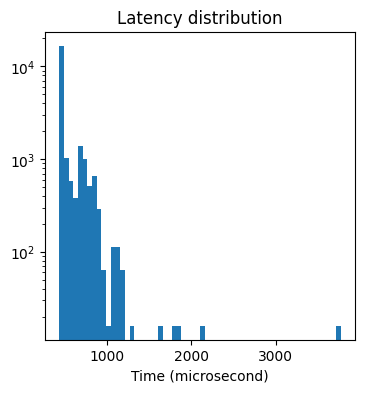

In [1001]:
fig,axs=plt.subplots(1, 1, figsize=(4, 4))
plt.hist(times, bins=60)
plt.yscale('log')
plt.title('Latency distribution')
plt.xlabel('Time (microsecond)');

In [1002]:
times.quantile([0.1, 0.5, 0.75, 0.9, 0.95, 0.99])

0.10     439.904004
0.50     449.112995
0.75     514.346997
0.90     738.791998
0.95     849.453005
0.99    1145.406997
dtype: float64

In [1003]:
times.mean()

526.0562745998277

slower than bollinger bands...

In [1004]:
# throughput without vectorisation
throughput_not_vec = len(X_te) / sum(times/1e6) 
print(f'Throughput (not vectorised): {throughput_not_vec} samples/second')

Throughput (not vectorised): 1900.9373108622312 samples/second


### torch.compile

a new feature in torch 2.0: https://pytorch.org/get-started/pytorch-2.0/#pytorch-2x-faster-more-pythonic-and-as-dynamic-as-ever

In [1031]:
torch._dynamo.reset()
compiled_model = torch.compile(model, mode="max-autotune")
compiled_model.eval();

In [1032]:
compiled_model(X_batch);

In [1033]:
times = []

all_y_true = []
all_y_preds = []
for X_batch, y_batch in loader:
    X_batch = X_batch.unsqueeze(0)
    y_batch = y_batch.unsqueeze(0)
    # so x shape is (batch_size, sequence length, features)
    
    start = timer()
    # USING COMPILED MODEL
    y_pred = compiled_model(X_batch)
    end = timer()

    times.extend([(end-start)]*X_batch.size(1))

    all_y_true.append(y_batch.detach().numpy())
    all_y_preds.append(y_pred.detach().numpy())
    
all_y_true = np.hstack(all_y_true).astype(int).ravel()
all_y_preds = np.hstack(all_y_preds).astype(int).ravel()
times = pd.Series(times)
times *= 1e6

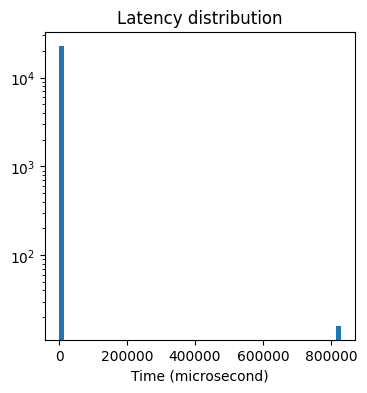

In [1034]:
fig,axs=plt.subplots(1, 1, figsize=(4, 4))
plt.hist(times, bins=60)
plt.yscale('log')
plt.title('Latency distribution')
plt.xlabel('Time (microsecond)');

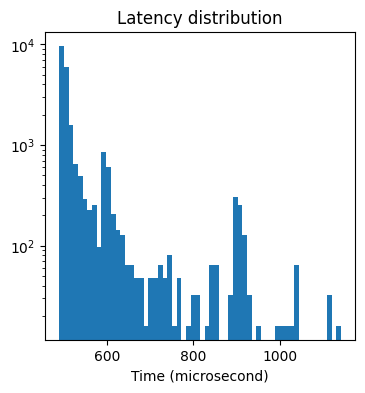

In [1038]:
fig,axs=plt.subplots(1, 1, figsize=(4, 4))
plt.hist(times[times < 200000], bins=60)
plt.yscale('log')
plt.title('Latency distribution')
plt.xlabel('Time (microsecond)');

In [1039]:
times.quantile([0.1, 0.5, 0.75, 0.9, 0.95, 0.99])

0.10    493.295003
0.50    500.948001
0.75    520.363996
0.90    606.501999
0.95    799.861999
0.99    926.183995
dtype: float64

In [1040]:
times.mean()

1115.7382657097924

latency distribution looks better, but still have a large outlier...

In [1041]:
# throughput without vectorisation
throughput_not_vec = len(X_te) / sum(times/1e6) 
print(f'Throughput (not vectorised): {throughput_not_vec} samples/second')

Throughput (not vectorised): 896.2675483428329 samples/second
